<a href="https://colab.research.google.com/github/djfLtC0dr/python-playground/blob/main/DASC522/djfDASC522hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sqlite3 Database & Helper Classes

In [239]:
import sqlparse
from sqlparse.sql import IdentifierList, Identifier,  Function
from sqlparse.tokens import Keyword, DML
from collections import namedtuple
import itertools
import sqlite3
import os
import pandas as pd
from typing import List

class Reference(namedtuple('Reference', ['schema', 'name', 'alias', 'is_function'])):
    __slots__ = ()

    def has_alias(self):
        return self.alias is not None

    @property
    def is_query_alias(self):
        return self.name is None and self.alias is not None

    @property
    def is_table_alias(self):
        return self.name is not None and self.alias is not None and not self.is_function

    @property
    def full_name(self):
        if self.schema is None:
            return self.name
        else:
            return self.schema + '.' + self.name

def _is_subselect(parsed):
    if not parsed.is_group:
        return False
    for item in parsed.tokens:
        if item.ttype is DML and item.value.upper() in ('SELECT', 'INSERT',
                                                        'UPDATE', 'CREATE', 'DELETE'):
            return True
    return False


def _identifier_is_function(identifier):
    return any(isinstance(t, Function) for t in identifier.tokens)


def _extract_from_part(parsed):
    tbl_prefix_seen = False
    for item in parsed.tokens:
        if item.is_group:
            for x in _extract_from_part(item):
                yield x
        if tbl_prefix_seen:
            if _is_subselect(item):
                for x in _extract_from_part(item):
                    yield x
            # An incomplete nested select won't be recognized correctly as a
            # sub-select. eg: 'SELECT * FROM (SELECT id FROM user'. This causes
            # the second FROM to trigger this elif condition resulting in a
            # StopIteration. So we need to ignore the keyword if the keyword
            # FROM.
            # Also 'SELECT * FROM abc JOIN def' will trigger this elif
            # condition. So we need to ignore the keyword JOIN and its variants
            # INNER JOIN, FULL OUTER JOIN, etc.
            elif item.ttype is Keyword and (
                    not item.value.upper() == 'FROM') and (
                    not item.value.upper().endswith('JOIN')):
                tbl_prefix_seen = False
            else:
                yield item
        elif item.ttype is Keyword or item.ttype is Keyword.DML:
            item_val = item.value.upper()
            if (item_val in ('COPY', 'FROM', 'INTO', 'UPDATE', 'TABLE') or
                    item_val.endswith('JOIN')):
                tbl_prefix_seen = True
        # 'SELECT a, FROM abc' will detect FROM as part of the column list.
        # So this check here is necessary.
        elif isinstance(item, IdentifierList):
            for identifier in item.get_identifiers():
                if (identifier.ttype is Keyword and
                        identifier.value.upper() == 'FROM'):
                    tbl_prefix_seen = True
                    break

def _extract_table_identifiers(token_stream):
    for item in token_stream:
        if isinstance(item, IdentifierList):
            for ident in item.get_identifiers():
                try:
                    alias = ident.get_alias()
                    schema_name = ident.get_parent_name()
                    real_name = ident.get_real_name()
                except AttributeError:
                    continue
                if real_name:
                    yield Reference(schema_name, real_name,
                                    alias, _identifier_is_function(ident))
        elif isinstance(item, Identifier):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))
        elif isinstance(item, Function):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))

def extract_tables(sql):
    # let's handle multiple statements in one sql string
    extracted_tables = []
    statements = list(sqlparse.parse(sql))
    for statement in statements:
        stream = _extract_from_part(statement)
        extracted_tables.append([ref.name for ref in _extract_table_identifiers(stream)])
    return list(itertools.chain(*extracted_tables))

class CSVDriver:
    def __init__(self, table_dir_path: str):
        self.table_dir_path = table_dir_path  # where tables (ie. csv files) are located
        self._con = None

    @property
    def con(self) -> sqlite3.Connection:
        """Make a singleton connection to an in-memory SQLite database"""
        if not self._con:
            self._con = sqlite3.connect(":memory:")
        return self._con
    
    def _exists(self, table: str) -> bool:
        query = """
        SELECT name
        FROM sqlite_master 
        WHERE type ='table'
        AND name NOT LIKE 'sqlite_%';
        """
        tables = self.con.execute(query).fetchall()
        return table in tables

    def _load_table_to_mem(self, table: str, sep: str = None) -> None:
        """
        Load a CSV into an in-memory SQLite database
        sep is set to None in order to force pandas to auto-detect the delimiter
        """
        if self._exists(table):
            return
        file_name = table + ".csv"
        path = os.path.join(self.table_dir_path, file_name)
        if not os.path.exists(path):
            raise ValueError(f"CSV table {table} does not exist in {self.table_dir_path}")
        df = pd.read_csv(path, sep=sep, engine="python")  # set engine to python to skip pandas' warning
        df.to_sql(table, self.con, if_exists='replace', index=False, chunksize=10000)

    def query(self, query: str) -> List[tuple]:
        """
        Run an SQL query on CSV file(s). 
        Tables are loaded from table_dir_path
        """
        tables = extract_tables(query)
        for table in tables:
            self._load_table_to_mem(table)
        cursor = self.con.cursor()
        cursor.execute(query)  # 'execute' for 1 statement 'executescript' for many
        records = cursor.fetchall()
        return records

Data Prep => Need to get Dates & Timestamps in same format

In [240]:
import csv
from datetime import datetime

sleep = 'sleep'
ready = 'readiness'
workout = 'workout'
mdy_format = '%m/%d/%Y'
input_files = [sleep, ready, workout] 

def parse_date(input_file):
  """
  Output csv to formatted dates to 
  faciliate SQL Join
  """
  with open(f"/{input_file}.csv", 'r') as infile, open(f"/t_{input_file}.csv", 'w') as outfile:
    reader = csv.reader(infile)
    headers = next(reader, None)  # returns the headers or `None` if the input is empty
    writer = csv.writer(outfile)
    if headers:
      writer.writerow(headers) # write the header line
    if input_file == sleep:
      for row in reader:
        dt = datetime.fromisoformat(row[1].replace('Z', '+00:00')) #parse the datetime 
        row[1] = dt.strftime(mdy_format)           #assign the revised format
        writer.writerow(row)  
    elif input_file == ready:
      for row in reader:      
        dt = datetime.strptime(row[0], '%Y-%m-%d')    #parse the datetime
        row[0] = dt.strftime(mdy_format)     #assign the revised format
        writer.writerow(row) 
    else: # workout
      for row in reader:    
        writer.writerow(row) # workout date is in mdy_format
  return     

for input_file in input_files:
    parse_date(input_file)

Load tables from database into Pandas dataframe object

In [241]:
db_path = r"/"
driver = CSVDriver(db_path) 
sel_query = """
SELECT S.overall_score, S.composition_score, S.revitalization_score, S.duration_score,
       S.deep_sleep_in_minutes, S.resting_heart_rate, S.restlessness,
       R.readiness_score_value, R.srl_normalized_score, R.ff_normalized_score, R.hrv_normalized_score,       
       W.notes AS rpe     
FROM t_sleep S
LEFT JOIN t_readiness R
ON S.timestamp = R.date
LEFT JOIN t_workout W
ON R.date = W.date
"""
# AND TRIM(W.pr) = 'PR';
data = pd.DataFrame.from_records(driver.query(sel_query))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       517 non-null    int64  
 1   1       517 non-null    int64  
 2   2       517 non-null    int64  
 3   3       517 non-null    int64  
 4   4       517 non-null    int64  
 5   5       517 non-null    int64  
 6   6       517 non-null    float64
 7   7       450 non-null    float64
 8   8       450 non-null    float64
 9   9       450 non-null    float64
 10  10      450 non-null    float64
 11  11      379 non-null    object 
dtypes: float64(5), int64(6), object(1)
memory usage: 48.6+ KB
None


Data Prep => we need to subset data by mask where @RPE exists

In [242]:
import warnings
warnings.filterwarnings('ignore')

mask = data[11].str.contains('@RPE', case=False, na=False)
data = data[mask]
# print(data.info())
# Extract all instances of RPE as int from notes = index 10
data[11] = data[11].str.extract(r'(@RPE+\d+)')
data[11] = data[11].str[4:].astype(float)


dict_col_names = {
    0: 'sleep_score',
    1: 'composite_score',
    2: 'revitalization_score',
    3: 'duration_score',
    4: 'deep_sleep_mins',
    5: 'resting_heart_rate',    
    6: 'restlessness',
    7: 'readiness_score',
    8: 'sleep_reservoir_lvl',
    9: 'fitness_fatigue',
    10: 'heart_rt_variability',
    11: 'rpe'
}

data.rename(dict_col_names, axis=1, inplace=True)
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 59 to 505
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sleep_score           115 non-null    int64  
 1   composite_score       115 non-null    int64  
 2   revitalization_score  115 non-null    int64  
 3   duration_score        115 non-null    int64  
 4   deep_sleep_mins       115 non-null    int64  
 5   resting_heart_rate    115 non-null    int64  
 6   restlessness          115 non-null    float64
 7   readiness_score       115 non-null    float64
 8   sleep_reservoir_lvl   115 non-null    float64
 9   fitness_fatigue       115 non-null    float64
 10  heart_rt_variability  115 non-null    float64
 11  rpe                   115 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 11.7 KB
None


,sleep_score,composite_score,revitalization_score,duration_score,deep_sleep_mins,resting_heart_rate,restlessness,readiness_score,sleep_reservoir_lvl,fitness_fatigue,heart_rt_variability,rpe
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,81.860870,20.191304,19.226087,42.443478,69.086957,52.556522,0.070932,66.573913,87.295652,67.530435,49.321739,5.904348
std,4.426568,1.577782,2.622644,2.464454,18.798827,1.665919,0.015129,25.304830,11.176396,24.727753,9.746387,4.879197
min,67.000000,15.000000,14.000000,35.000000,27.000000,49.000000,0.043157,7.000000,23.000000,7.000000,26.000000,1.000000
25%,79.500000,19.000000,17.000000,41.000000,58.000000,52.000000,0.061139,50.000000,85.000000,54.500000,42.000000,3.000000
50%,82.000000,21.000000,20.000000,43.000000,66.000000,53.000000,0.067358,69.000000,90.000000,72.000000,49.000000,5.000000
75%,85.000000,21.000000,21.000000,43.000000,82.000000,54.000000,0.076072,88.000000,93.000000,88.000000,56.000000,8.000000
max,90.000000,23.000000,24.000000,47.000000,121.000000,57.000000,0.116041,100.000000,99.000000,100.000000,82.000000,51.000000


Data clean-up => fix outlier(s), DU

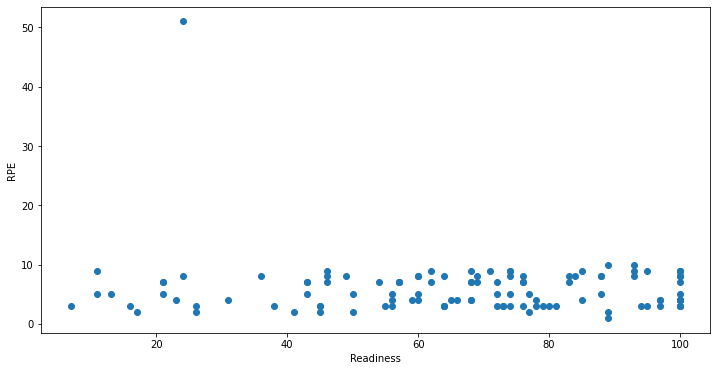

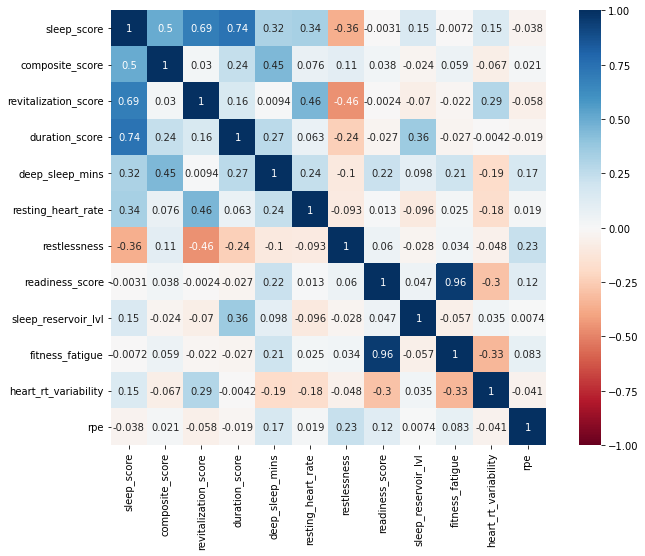

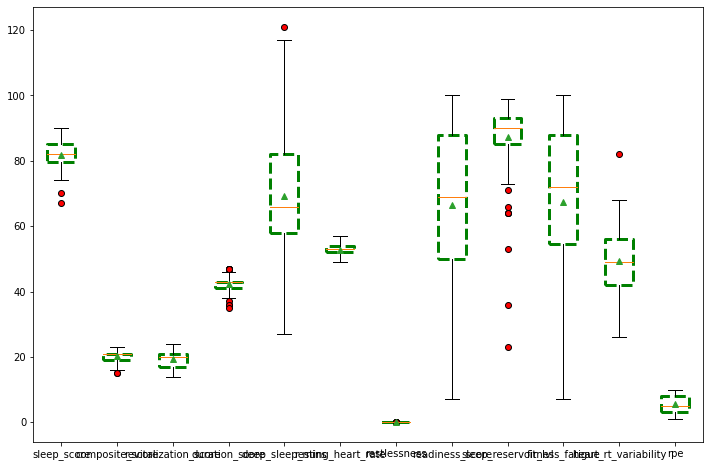

,sleep_score,composite_score,revitalization_score,duration_score,deep_sleep_mins,resting_heart_rate,restlessness,readiness_score,sleep_reservoir_lvl,fitness_fatigue,heart_rt_variability,rpe
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,81.860870,20.191304,19.226087,42.443478,69.086957,52.556522,0.070932,66.573913,87.295652,67.530435,49.321739,5.504348
std,4.426568,1.577782,2.622644,2.464454,18.798827,1.665919,0.015129,25.304830,11.176396,24.727753,9.746387,2.411136
min,67.000000,15.000000,14.000000,35.000000,27.000000,49.000000,0.043157,7.000000,23.000000,7.000000,26.000000,1.000000
25%,79.500000,19.000000,17.000000,41.000000,58.000000,52.000000,0.061139,50.000000,85.000000,54.500000,42.000000,3.000000
50%,82.000000,21.000000,20.000000,43.000000,66.000000,53.000000,0.067358,69.000000,90.000000,72.000000,49.000000,5.000000
75%,85.000000,21.000000,21.000000,43.000000,82.000000,54.000000,0.076072,88.000000,93.000000,88.000000,56.000000,8.000000
max,90.000000,23.000000,24.000000,47.000000,121.000000,57.000000,0.116041,100.000000,99.000000,100.000000,82.000000,10.000000


In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(data['readiness_score'], data['rpe'])
ax.set_xlabel('Readiness')
ax.set_ylabel('RPE')
plt.show()

# Z score
z = np.abs(stats.zscore(data['rpe']))
threshold = 3

# Position of the outlier
idx_outlier = np.where(z > threshold)
# print(data.iloc[idx_outlier])

median_rpe = data['rpe'].quantile(0.50)
outlier_rpe = data['rpe'].quantile(0.9915)
# print(outlier_rpe)
# Any thing over 10 needs to be replaced with the median rpe
data['rpe'] = np.where(data['rpe'] > outlier_rpe, int(median_rpe), data['rpe'])

# correlation matrix
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(data.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

#visualizing distributions 
fig, ax = plt.subplots(figsize=(12,8))
ticks = range(1, len(data.columns)+1)
labels = list(data.columns)
boxprops = dict(linestyle='--', linewidth=3, color='green')
flierprops = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
plt.boxplot(data.transpose(), showmeans=True, boxprops=boxprops, flierprops=flierprops)
plt.xticks(ticks,labels)
plt.show()

data.describe()

Data Prep => Multicollinearity

In [244]:
#Applying multicollinearity to remove columns which are dependent on each other
# From looking at documentation, values between 5 and 10 are "okay".
# Above 10 is too high and so should be removed.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=20, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        # I'm going to set it to 20 and see what happens
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            try:
                vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
                max_vif = max(vif)
                if max_vif > thresh:
                    maxloc = vif.index(max_vif)
                    print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                    X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                    dropped=True
            except ValueError:  #raised if `vif` is empty.
                pass
        return X

# Remove columns having higher VIF factor that have high multicollinearity
multicollinearity = ReduceVIF()
data = multicollinearity.fit_transform(data)
print(data.columns)

ReduceVIF fit
ReduceVIF transform
Dropping sleep_score with vif=inf
Dropping resting_heart_rate with vif=498.43902767113656
Dropping duration_score with vif=291.60009949426507
Dropping composite_score with vif=161.51935049378764
Dropping fitness_fatigue with vif=108.42756312622791
Dropping revitalization_score with vif=46.43237048057355
Dropping sleep_reservoir_lvl with vif=40.39768678110176
Index(['deep_sleep_mins', 'restlessness', 'readiness_score',
       'heart_rt_variability', 'rpe'],
      dtype='object')


DU => pairplot RPE

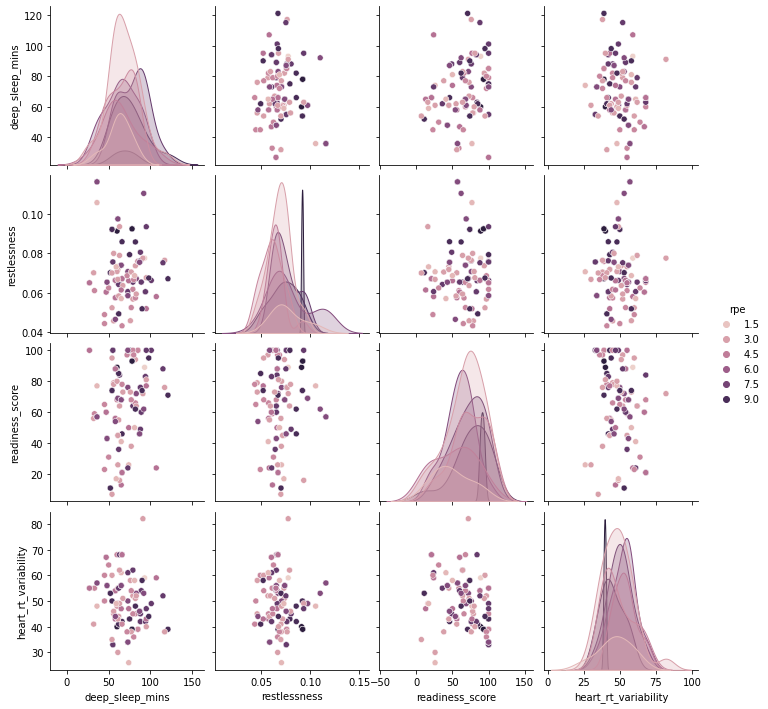

In [245]:
# pairplot with hue rpe
sns.pairplot(data, hue ='rpe')
plt.show()

Feature Engineering => pre-processing, dimension reduction

In [246]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE, f_classif, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# separate the independent and dependent variables
X = data.loc[:, data.columns != 'rpe']
y = data.loc[:, data.columns == 'rpe']
# X = sm.add_constant(X)

# for future piping
numeric_features = list(X.select_dtypes(include=['float64', 'int64']).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# reduce dimensions to explain 95% variance
pca = PCA(n_components=0.95)

# split normd data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

Modeling => Regression MLP

In [262]:
try:
    import scikeras
except ImportError:
    !pip install scikeras

from typing import Dict, Iterable, Any
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Input, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.metrics import MeanSquaredError
from keras.callbacks import EarlyStopping

# Silence TensorFlow logging to keep output succinct.
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

class MLPRegressor(KerasRegressor):

    def __init__(
        self,
        hidden_layer_sizes=(20, ),
        optimizer='adam',
        optimizer__learning_rate=0.001,
        batch_size=2,
        epochs=200,
        verbose=0,
        dropout=0.5,
        callbacks=[EarlyStopping(patience=10)],
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.dropout = dropout    

    def _keras_build_fn(self, compile_kwargs: Dict[str, Any]):
        model = Sequential()
        inp = Input(shape=(self.n_features_in_))
        model.add(inp)
        for hidden_layer_size in self.hidden_layer_sizes:
            layer = Dense(hidden_layer_size, activation='relu')
            drop_out = Dropout(self.dropout)
            model.add(layer)
            model.add(drop_out)
        out = Dense(1, activation='linear') # , activation='relu' Only positive 
        model.add(out)
        model.compile(loss='mse', optimizer=compile_kwargs['optimizer'], metrics=[MeanSquaredError()])
        return model

# evaluate model with standardized dataset
pipe=Pipeline(steps=[('preprocessor', preprocessor),
                     ('pca', pca),
                     ('estimator', MLPRegressor())])
pipe.fit(X_train, y_train)
kfold = KFold(n_splits=10)
results = cross_val_score(pipe, X_test, y_test, cv=kfold, scoring='neg_mean_squared_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (results.mean(), results.std()))

-13.82 accuracy with a standard deviation of 11.69


Modeling => prediction plots

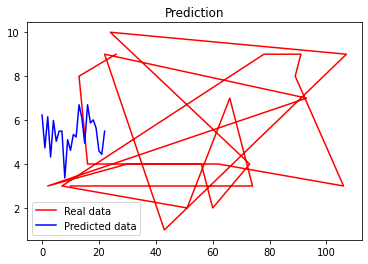

In [263]:
y_pred = pipe.predict(X_test)
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

Model Evaluation:

The data analysis began by exporting the data in CSV format then preparing the data by joining the files by date. The data cleaning steps included fixing outliers and extracting RPE from session notes and formatting it as float.

After the data understanding, it was clear we had some multicollinearity issues to fix. After running the VIF function we dropped down to five viable features. This was further validated with RPA/C dimension reduction pipelines.

For best P-value modeling StatsModels.OLS regression was used to summaraize the model. All features with pvals > 0.05 were dropped, slightly improving  Adj. R-squared and left two significant features, shown here with their respective P-values: 


1.   restlessness             0.008       
2.   deep_sleep_mins          0.032

R-squared: 0.090

The AIC modeling leveraged the itertools library to perform an "Every model possible" build. The lowest scoring AIC dataset returned the same significant variables as the P-value modeling:

1.   restlessness             0.008       
2.   deep_sleep_mins          0.032

R-squared: 0.090 

Lastly, RFE modeling iterated over the five viable features and determined the three best scoring features were:

1.   restlessness             0.009 
2.   deep_sleep_mins          0.055      
3.   readiness_score          0.475

R-squared: 0.094

In summary, the modeling results presented here cannot be used to answer the problem. Although we determined some significant features, it is not a "good" model as its low R-squared doesn't add much value beyond what the mean(RPE) does in terms of predicting session RPE. Case in point, two extreme test datasets from the AIC Model returned approximately the same predicted RPE as the mean(RPE) of 5.904348:

```
test_data = [{'deep_sleep_mins': 40, 'restlessness': 0.10553633217993},
             {'deep_sleep_mins': 120, 'restlessness': 0.044131455399061}
            ]
test_input = pd.DataFrame.from_records(test_data)
rpe_prediction = aic_model.predict(test_input)
print(rpe_prediction) => 
0    6.131021
1    5.734243
```

